In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
from astropy.stats.circstats import circcorrcoef

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from modelUtils import wrap_180, rot
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

from SacNetwork import SacNetwork
import balance_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

# TODO:
**timing offsets between EI for each direction:**
- collect input locations for EI synapses at each rho level
- calculate the time delta between E and I
- how does this change over direction?

In [4]:
rng = np.random.default_rng()
dir_labels = np.array([225, 270, 315, 0, 45, 90, 135, 180])
dir_rads = np.radians(dir_labels)
conf = configs.sac_mode_config()
probs = {
    t: {
        "null": conf["synprops"][t]["null_prob"],
        "pref": conf["synprops"][t]["pref_prob"],
    }
    for t in ["E", "I"]
}

In [5]:
def calc_sweep_times(
    thetas, # shape (N, 2 [EI])
    locs, # shape (N, 2 [EI], 2 [XY])
    origin,
    vel=1.0,
    rel_start=np.array([-150, 0]),
    rel_end=np.array([150, 0]),
):
    times = {}  # dir -> syn -> trans
    for i, r in enumerate(dir_rads):
        times[i] = {}
        line_a = rot(r, rel_start) + origin
        line_b = rot(r, rel_end) + origin
        for syn in range(thetas.shape[0]):
            times[i][syn] = np.zeros(2)
            for j in range(2):
                dist = project_onto_line(line_a, line_b, locs[syn][j])[0]
                times[i][syn][j] = dist / vel
                
    return times

In [9]:
n_syns = 1000
rho_steps = 50
rhos = np.arange(rho_steps + 1) / rho_steps 

thetas, deltas, abs_deltas, dir_probs, times = [{} for _ in range(5)]
corrs, mean_abs_deltas = [], []

for rho in rhos:
    sac_net = SacNetwork(
        np.zeros((n_syns, 2)),
        probs,
        rho,
        conf["sac_uniform_dist"],
        conf["sac_shared_var"],
        conf["sac_theta_vars"],
        conf["sac_gaba_coverage"],
        dir_labels,
        rng,
        offset=conf["sac_offset"],
        theta_mode=conf["sac_theta_mode"],
        cell_pref=0,
        n_plexus_ach=0,
    )
    n = np.sum(sac_net.gaba_here)
    ts = np.zeros((n, 2))
    ts[:, 0] = sac_net.thetas["E"][sac_net.gaba_here]
    ts[:, 1] = sac_net.thetas["I"][sac_net.gaba_here]
    thetas[rho] = ts
    corrs.append(circcorrcoef(np.radians(ts[:, 0]), np.radians(ts[:, 1])))
    deltas[rho] = np.vectorize(wrap_180)(ts[:, 0] - ts[:, 1])
    abs_deltas[rho] = np.abs(deltas[rho])
    mean_abs_deltas.append(np.mean(abs_deltas[rho]))
    locs = np.zeros((n, 2, 2))
    locs[:, 0, :] = sac_net.bp_locs["E"][sac_net.gaba_here]
    locs[:, 1, :] = sac_net.bp_locs["I"][sac_net.gaba_here]
    times[rho] = calc_sweep_times(ts, locs, sac_net.origin)
    dir_probs[rho] = np.zeros((n, 8, 2))
    dir_probs[rho][:, :, 0] = sac_net.probs["E"][sac_net.gaba_here]
    dir_probs[rho][:, :, 1] = sac_net.probs["I"][sac_net.gaba_here]

corrs = np.array(corrs)

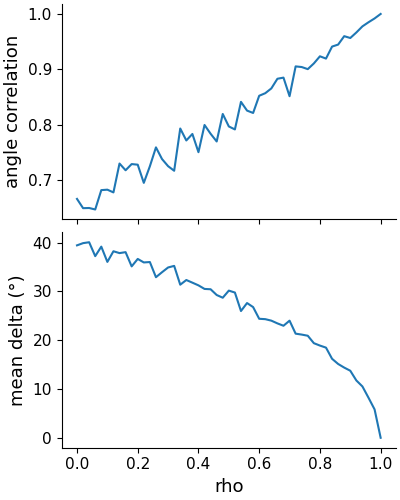

In [10]:
real_corr_fig, real_corr_ax = plt.subplots(2, 1, sharex=True, figsize=(4, 5))
real_corr_ax[0].plot(rhos, corrs)
real_corr_ax[0].set_ylabel("angle correlation", fontsize=13)
real_corr_ax[1].plot(rhos, mean_abs_deltas)
real_corr_ax[1].set_ylabel("mean delta (°)", fontsize=13)
real_corr_ax[-1].set_xlabel("rho", fontsize=13)
real_corr_fig.set_layout_engine("compressed")
clean_axes(real_corr_ax)